In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [5]:
dataset = pd.read_csv("traffic.csv")
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [6]:
dataset["DateTime"]= pd.to_datetime(dataset["DateTime"])
dataset = dataset.drop(["ID"], axis=1) #dropping IDs column
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

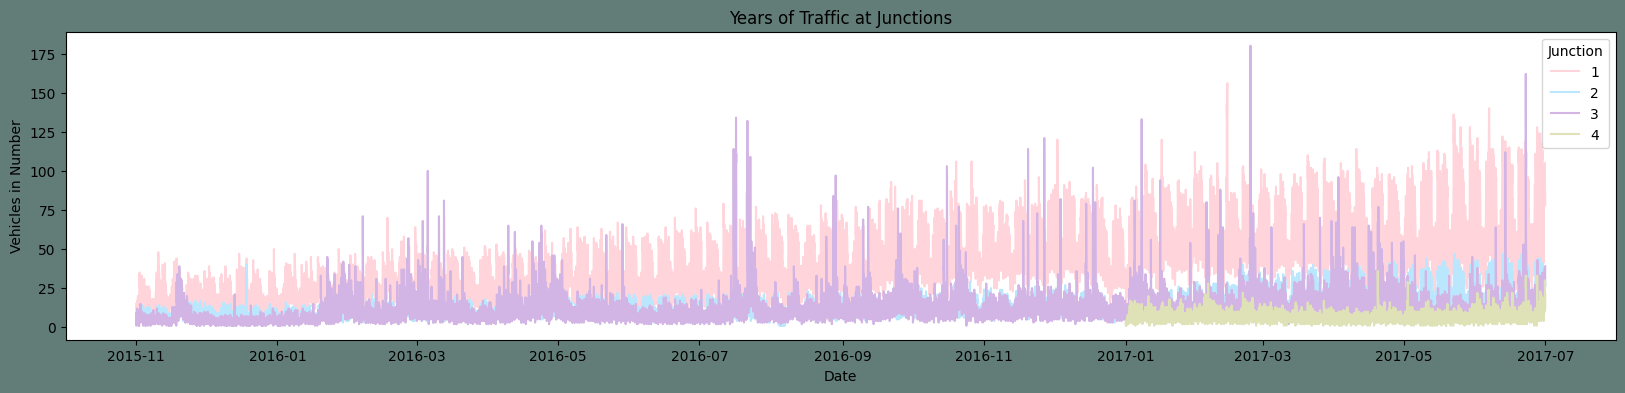

In [7]:
dataframe=dataset.copy()

# Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=dataframe['DateTime'],y="Vehicles",data=dataframe, hue="Junction", palette=colors)
Time_series.set_title("Years of Traffic at Junctions")
Time_series.set_ylabel("Vehicles in Number")
Time_series.set_xlabel("Date")

In [9]:
dataframe["Year"]= dataframe['DateTime'].dt.year
dataframe["Month"]= dataframe['DateTime'].dt.month
dataframe["Date_no"]= dataframe['DateTime'].dt.day
dataframe["Hour"]= dataframe['DateTime'].dt.hour
dataframe["Day"]= dataframe.DateTime.dt.strftime("%A")
dataframe.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


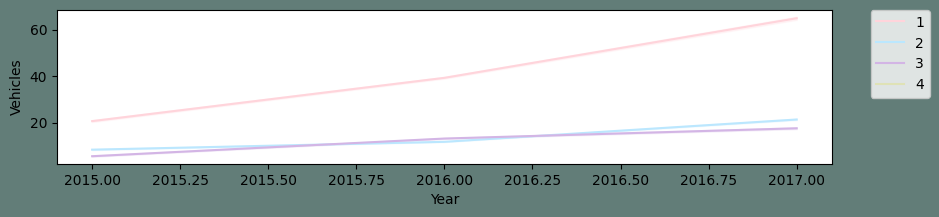

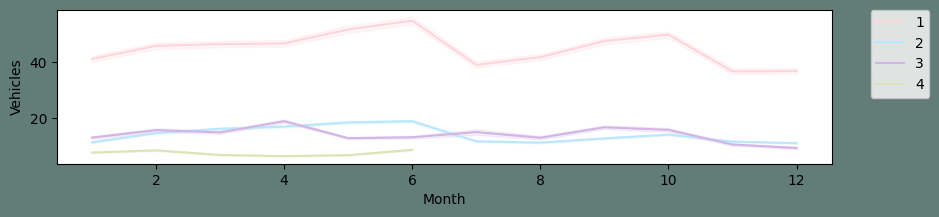

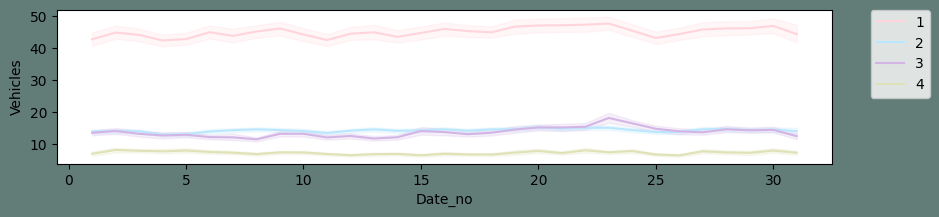

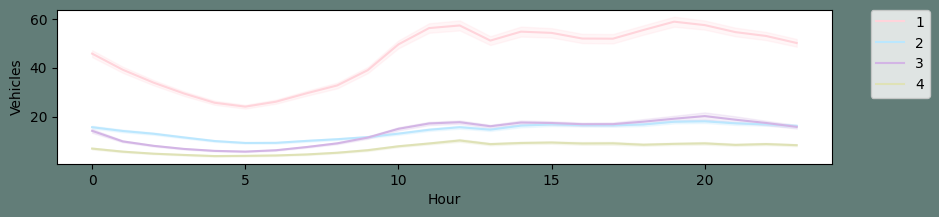

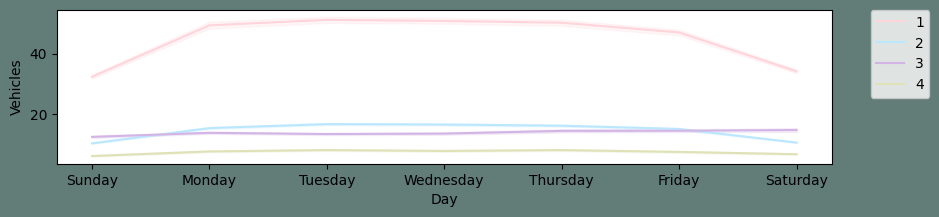

In [10]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=dataframe[i],y="Vehicles",data=dataframe, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

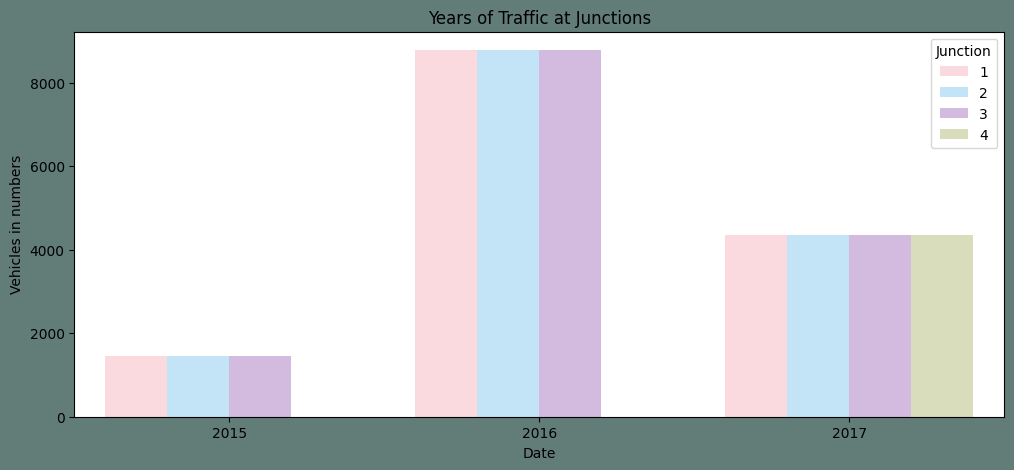

In [11]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=dataframe, x =dataframe["Year"], hue="Junction", palette=colors)
count.set_title("Years of Traffic at Junctions")
count.set_ylabel("Vehicles in numbers")
count.set_xlabel("Date")

<Axes: >

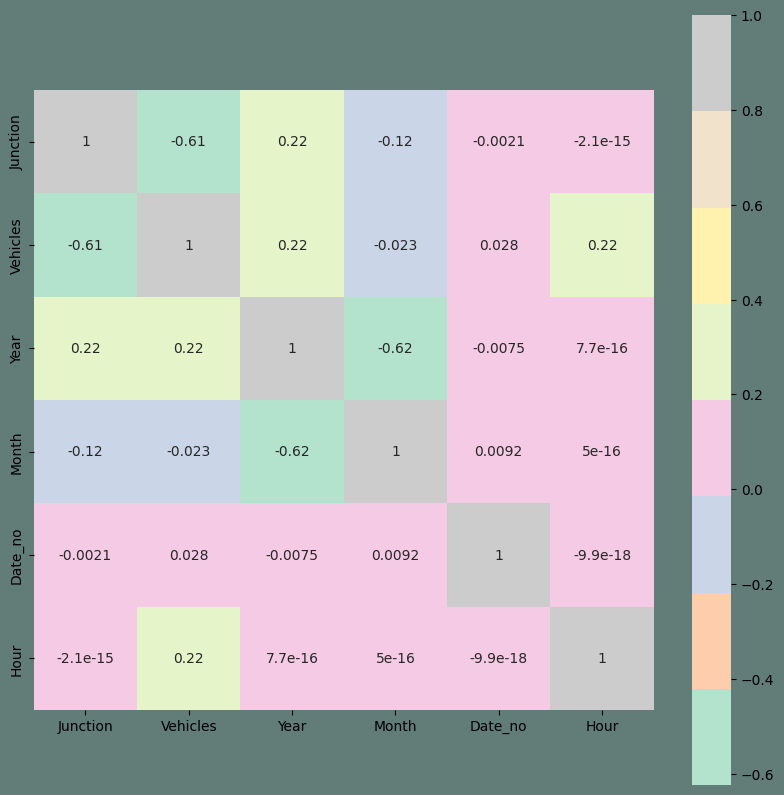

In [12]:
corrmat = dataframe.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

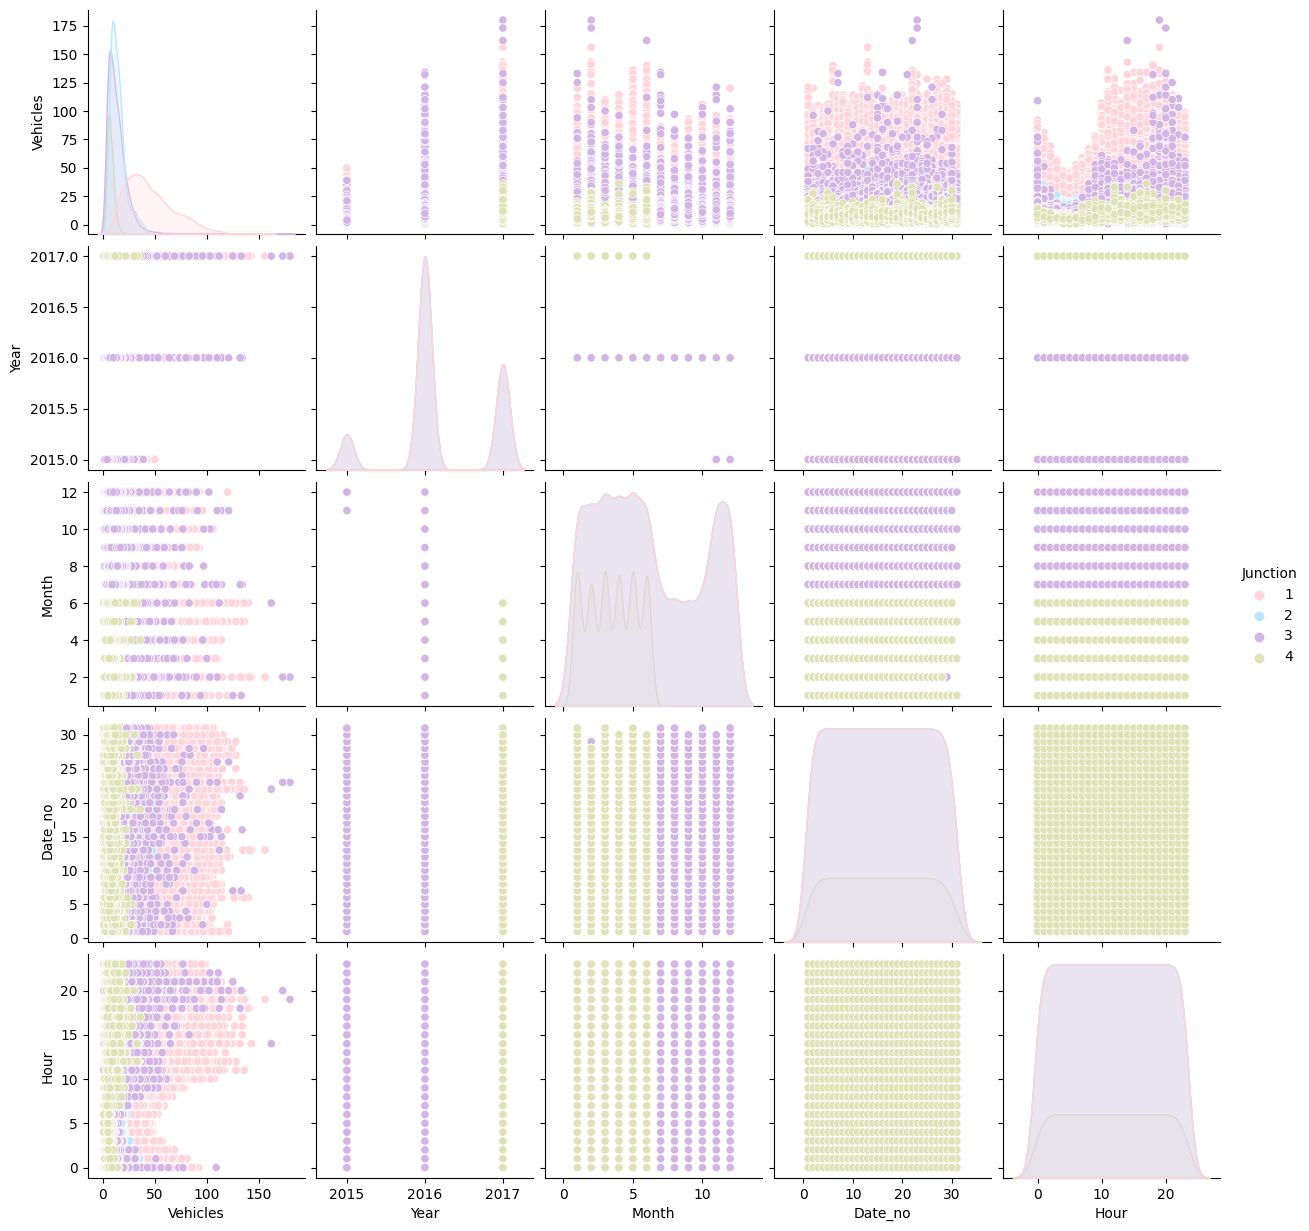

In [13]:
sns.pairplot(data=dataframe, hue= "Junction",palette=colors)

In [14]:
# Pivoting dataset from junction
dataframe_junction = dataset.pivot(columns="Junction", index="DateTime")
dataframe_junction.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

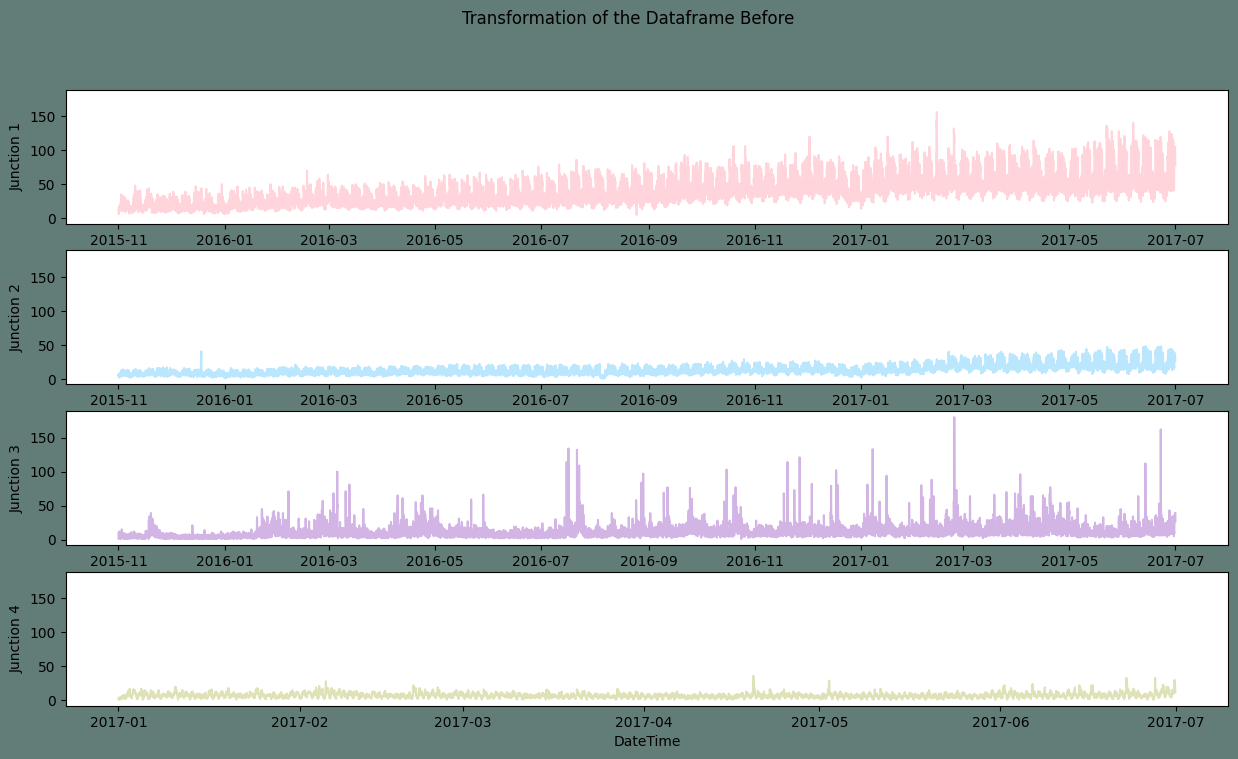

In [15]:
dataframe_1 = dataframe_junction[[('Vehicles', 1)]]
dataframe_2 = dataframe_junction[[('Vehicles', 2)]]
dataframe_3 = dataframe_junction[[('Vehicles', 3)]]
dataframe_4 = dataframe_junction[[('Vehicles', 4)]]
dataframe_4 = dataframe_4.dropna() #For only a few months, Junction 4 has only had minimal data.

# As DFS's data frame contains many indices, its index is lowering level one.
list_dfs = [dataframe_1, dataframe_2, dataframe_3, dataframe_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

# Creates comparison dataframe charts using this function
def Sub_Plots4(dataframe_1, dataframe_2,dataframe_3,dataframe_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=dataframe_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=dataframe_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=dataframe_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=dataframe_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


# It is displayed to test for stationarity.
Sub_Plots4(dataframe_1.Vehicles, dataframe_2.Vehicles,dataframe_3.Vehicles,dataframe_4.Vehicles,"Transformation of the Dataframe Before")

In [16]:
# Normalize Function
def Normalize(dataframe,column):
    average = dataframe[column].mean()
    stdev = dataframe[column].std()
    df_normalized = (dataframe[column] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(dataframe,column, interval):
    diff = []
    for i in range(interval, len(dataframe)):
        value = dataframe[column][i] - dataframe[column][i - interval]
        diff.append(value)
    return diff

In [17]:
# In order to make the series stationary, normalize and differ
dataframe_N1, avg_J1, std_J1 = Normalize(dataframe_1, "Vehicles")
Diff_1 = Difference(dataframe_N1, column="Vehicles", interval=(24*7)) #taking a week's difference
dataframe_N1 = dataframe_N1[24*7:]
dataframe_N1.columns = ["Norm"]
dataframe_N1["Diff"]= Diff_1

dataframe_N2, avg_J2, std_J2 = Normalize(dataframe_2, "Vehicles")
Diff_2 = Difference(dataframe_N2, column="Vehicles", interval=(24)) #taking a day's difference
dataframe_N2 = dataframe_N2[24:]
dataframe_N2.columns = ["Norm"]
dataframe_N2["Diff"]= Diff_2

dataframe_N3, avg_J3, std_J3 = Normalize(dataframe_3, "Vehicles")
Diff_3 = Difference(dataframe_N3, column="Vehicles", interval=1) #taking an hour's difference
dataframe_N3 = dataframe_N3[1:]
dataframe_N3.columns = ["Norm"]
dataframe_N3["Diff"]= Diff_3

dataframe_N4, avg_J4, std_J4 = Normalize(dataframe_4, "Vehicles")
Diff_4 = Difference(dataframe_N4, column="Vehicles", interval=1) #taking an hour's difference
dataframe_N4 = dataframe_N4[1:]
dataframe_N4.columns = ["Norm"]
dataframe_N4["Diff"]= Diff_4

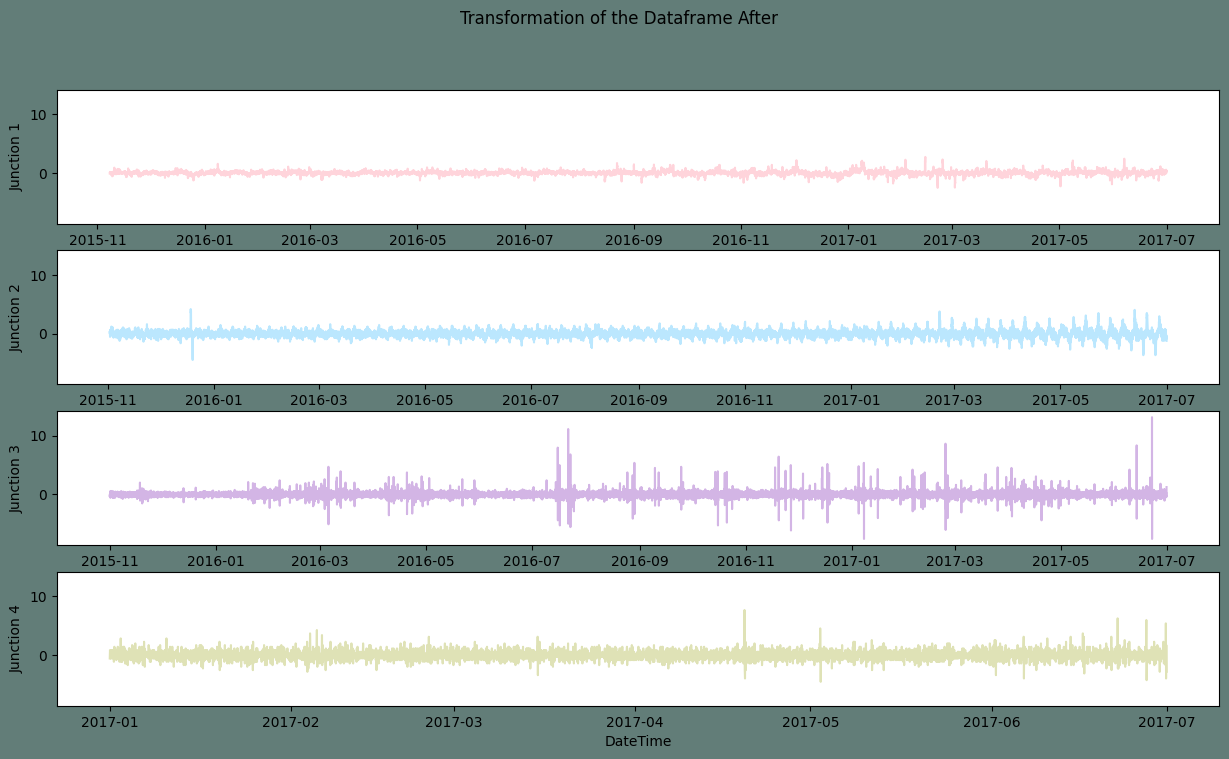

In [18]:
Sub_Plots4(dataframe_N1.Diff, dataframe_N2.Diff,dataframe_N3.Diff,dataframe_N4.Diff,"Transformation of the Dataframe After")

In [19]:
def Stationary_check(dataframe):
    check = adfuller(dataframe.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


# examining the series' stationary state

List_df_ND = [ dataframe_N1["Diff"], dataframe_N2["Diff"], dataframe_N3["Diff"], dataframe_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [20]:
dataframe_J1 = dataframe_N1["Diff"].dropna()
dataframe_J1 = dataframe_J1.to_frame()

dataframe_J2 = dataframe_N2["Diff"].dropna()
dataframe_J2 = dataframe_J2.to_frame()

dataframe_J3 = dataframe_N3["Diff"].dropna()
dataframe_J3 = dataframe_J3.to_frame()

dataframe_J4 = dataframe_N4["Diff"].dropna()
dataframe_J4 = dataframe_J4.to_frame()

# Splitting the dataset
def Split_data(dataframe):
    training_size = int(len(dataframe)*0.90)
    data_len = len(dataframe)
    train, test = dataframe[0:training_size],dataframe[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
# Splitting the training and test datasets
Junction1_train, Junction1_test = Split_data(dataframe_J1)
Junction2_train, Junction2_test = Split_data(dataframe_J2)
Junction3_train, Junction3_test = Split_data(dataframe_J3)
Junction4_train, Junction4_test = Split_data(dataframe_J4)

# Target and Feature
def target_and_feature(dataframe):
    end_len = len(dataframe)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(dataframe[i - steps:i, 0])
        y.append(dataframe[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

# fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

# Assigning features and target
X_train_Junction1, y_train_Junction1 = target_and_feature(Junction1_train)
X_test_Junction1, y_test_Junction1 = target_and_feature(Junction1_test)
X_train_Junction1, X_test_Junction1 = FeatureFixShape(X_train_Junction1, X_test_Junction1)

X_train_Junction2, y_train_Junction2 = target_and_feature(Junction2_train)
X_test_Junction2, y_test_Junction2 = target_and_feature(Junction2_test)
X_train_Junction2, X_test_Junction2 = FeatureFixShape(X_train_Junction2, X_test_Junction2)

X_train_Junction3, y_train_Junction3 = target_and_feature(Junction3_train)
X_test_Junction3, y_test_Junction3 = target_and_feature(Junction3_test)
X_train_Junction3, X_test_Junction3 = FeatureFixShape(X_train_Junction3, X_test_Junction3)

X_train_Junction4, y_train_Junction4 = target_and_feature(Junction4_train)
x_test_Junction4, y_test_Junction4 = target_and_feature(Junction4_test)
X_train_Junction4, x_test_Junction4 = FeatureFixShape(X_train_Junction4, x_test_Junction4)

In [36]:
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=10, restore_best_weights=True)

    # The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))

    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Defining the learning rate schedule
    lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=10000,
        decay_rate=0.9)

    # Compiling the model with the learning rate schedule
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9), loss='mean_squared_error')
    model.fit(X_Train, y_Train, epochs=50, batch_size=150, callbacks=[early_stopping])
    pred_GRU = model.predict(X_Test)
    return pred_GRU


# To determine the root mean squared prediction error
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

# Plotting the goal and forecast comparison plot
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [31]:
PredJ1 = GRU_model(X_train_Junction1,y_train_Junction1,X_test_Junction1)

Epoch 1/50
87/87 [==============================] - 44s 391ms/step - loss: 0.0758
Epoch 2/50
87/87 [==============================] - 34s 386ms/step - loss: 0.0658
Epoch 3/50
87/87 [==============================] - 35s 400ms/step - loss: 0.0645
Epoch 4/50
87/87 [==============================] - 34s 394ms/step - loss: 0.0627
Epoch 5/50
87/87 [==============================] - 33s 376ms/step - loss: 0.0611
Epoch 6/50
87/87 [==============================] - 34s 391ms/step - loss: 0.0606
Epoch 7/50
87/87 [==============================] - 35s 400ms/step - loss: 0.0594
Epoch 8/50
87/87 [==============================] - 33s 378ms/step - loss: 0.0583
Epoch 9/50
87/87 [==============================] - 34s 394ms/step - loss: 0.0576
Epoch 10/50
87/87 [==============================] - 34s 395ms/step - loss: 0.0580
Epoch 11/50
87/87 [==============================] - 33s 377ms/step - loss: 0.0568
Epoch 12/50
87/87 [==============================] - 34s 391ms/step - loss: 0.0561
Epoch 13/50
8

The root mean squared error is 0.2459614159037839.


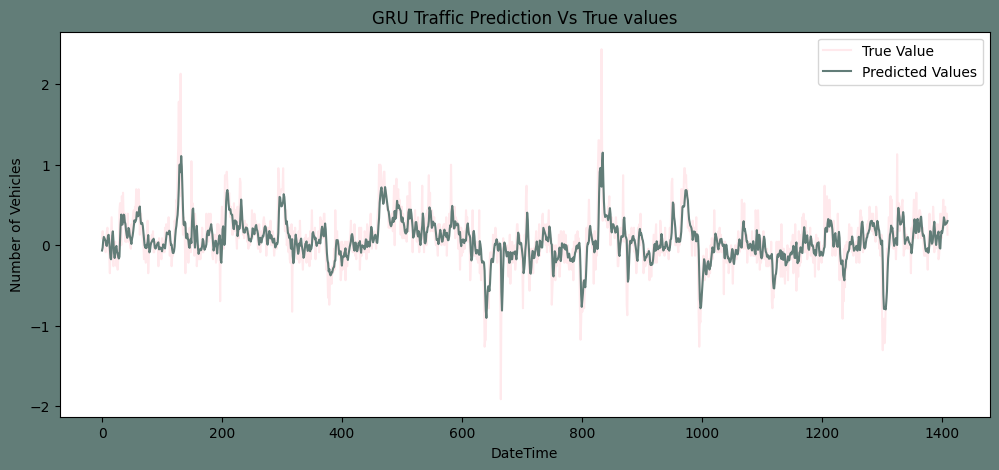

In [37]:
RMSE_J1=RMSE_Value(y_test_Junction1,PredJ1)
PredictionsPlot(y_test_Junction1,PredJ1,0)

In [42]:
PredJ2 = GRU_model(X_train_Junction2, y_train_Junction2, X_test_Junction2)

Epoch 1/50
88/88 [==============================] - 46s 392ms/step - loss: 0.2311
Epoch 2/50
88/88 [==============================] - 36s 404ms/step - loss: 0.2072
Epoch 3/50
88/88 [==============================] - 35s 402ms/step - loss: 0.1990
Epoch 4/50
88/88 [==============================] - 35s 402ms/step - loss: 0.1967
Epoch 5/50
88/88 [==============================] - 34s 390ms/step - loss: 0.1938
Epoch 6/50
88/88 [==============================] - 37s 416ms/step - loss: 0.1931
Epoch 7/50
88/88 [==============================] - 35s 402ms/step - loss: 0.1914
Epoch 8/50
88/88 [==============================] - 36s 407ms/step - loss: 0.1902
Epoch 9/50
88/88 [==============================] - 36s 407ms/step - loss: 0.1921
Epoch 10/50
88/88 [==============================] - 35s 393ms/step - loss: 0.1891
Epoch 11/50
88/88 [==============================] - 36s 405ms/step - loss: 0.1881
Epoch 12/50
88/88 [==============================] - 35s 403ms/step - loss: 0.1889
Epoch 13/50
8

The root mean squared error is 0.576309077553076.


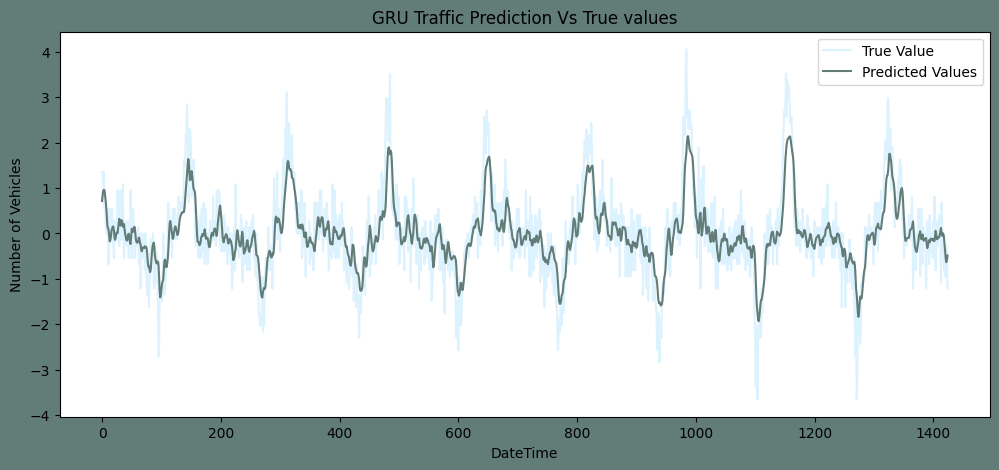

In [43]:
#Results for J2
RMSE_J2=RMSE_Value(y_test_Junction2,PredJ2)
PredictionsPlot(y_test_Junction2,PredJ2,1)

In [44]:
PredJ3 = GRU_model(X_train_Junction3,y_train_Junction3,X_test_Junction3)

Epoch 1/50
88/88 [==============================] - 43s 374ms/step - loss: 0.3030
Epoch 2/50
88/88 [==============================] - 36s 408ms/step - loss: 0.2955
Epoch 3/50
88/88 [==============================] - 35s 404ms/step - loss: 0.2923
Epoch 4/50
88/88 [==============================] - 36s 411ms/step - loss: 0.2902
Epoch 5/50
88/88 [==============================] - 36s 409ms/step - loss: 0.2903
Epoch 6/50
88/88 [==============================] - 35s 395ms/step - loss: 0.2877
Epoch 7/50
88/88 [==============================] - 36s 408ms/step - loss: 0.2909
Epoch 8/50
88/88 [==============================] - 37s 420ms/step - loss: 0.2876
Epoch 9/50
88/88 [==============================] - 36s 412ms/step - loss: 0.2860
Epoch 10/50
88/88 [==============================] - 41s 467ms/step - loss: 0.2895
Epoch 11/50
88/88 [==============================] - 39s 448ms/step - loss: 0.2884
Epoch 12/50
88/88 [==============================] - 41s 461ms/step - loss: 0.2860
Epoch 13/50
8

The root mean squared error is 0.6099043989371941.


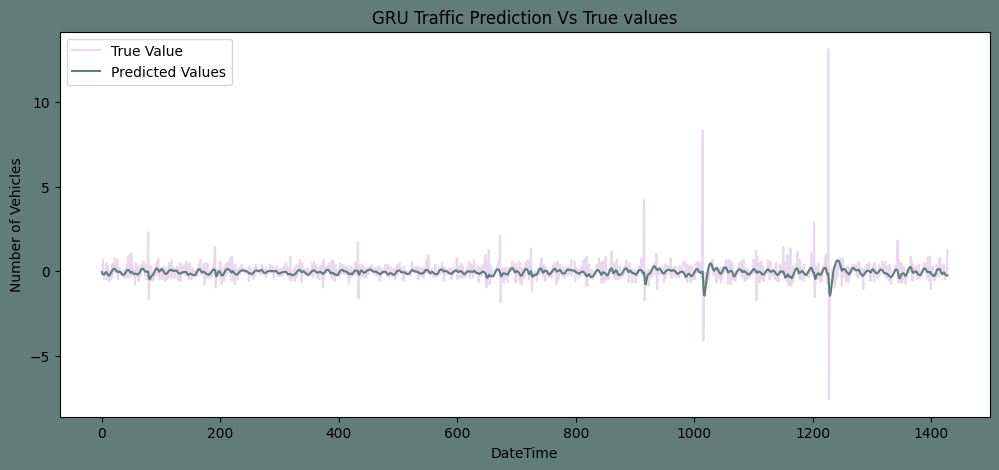

In [45]:
RMSE_J3=RMSE_Value(y_test_Junction3,PredJ3)
PredictionsPlot(y_test_Junction3,PredJ3,2)

In [46]:
PredJ4 = GRU_model(X_train_Junction4,y_train_Junction4,x_test_Junction4)

Epoch 1/50
26/26 [==============================] - 21s 392ms/step - loss: 0.6919
Epoch 2/50
26/26 [==============================] - 11s 410ms/step - loss: 0.6909
Epoch 3/50
26/26 [==============================] - 11s 407ms/step - loss: 0.6881
Epoch 4/50
26/26 [==============================] - 11s 409ms/step - loss: 0.6895
Epoch 5/50
26/26 [==============================] - 11s 416ms/step - loss: 0.6840
Epoch 6/50
26/26 [==============================] - 10s 367ms/step - loss: 0.6836
Epoch 7/50
26/26 [==============================] - 12s 426ms/step - loss: 0.6844
Epoch 8/50
26/26 [==============================] - 11s 415ms/step - loss: 0.6815
Epoch 9/50
26/26 [==============================] - 11s 412ms/step - loss: 0.6823
Epoch 10/50
26/26 [==============================] - 11s 414ms/step - loss: 0.6792
Epoch 11/50
26/26 [==============================] - 11s 409ms/step - loss: 0.6771
Epoch 12/50
26/26 [==============================] - 9s 363ms/step - loss: 0.6780
Epoch 13/50
26

The root mean squared error is 1.0098956439367472.


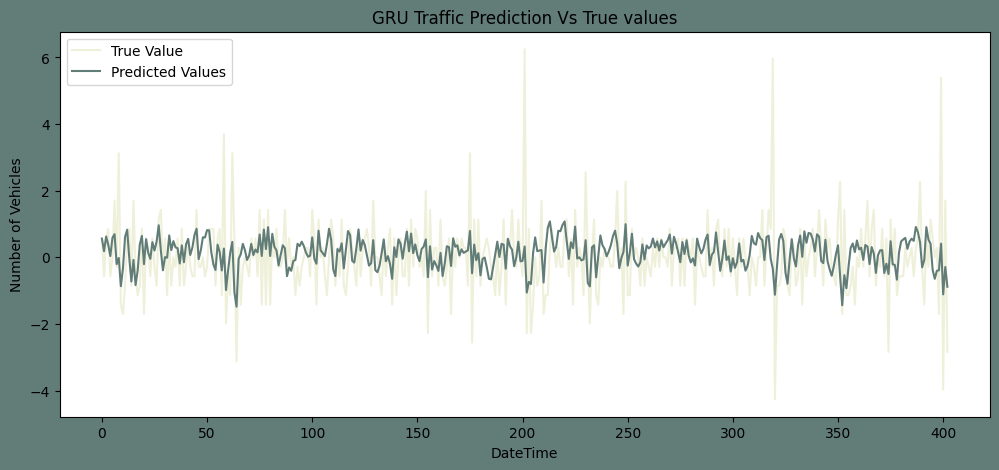

In [47]:
RMSE_J4=RMSE_Value(y_test_Junction4,PredJ4)
PredictionsPlot(y_test_Junction4,PredJ4,3)

In [48]:
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]
list_of_tuples = list(zip(Junctions, RMSE))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])
Results.style.background_gradient(cmap="Pastel1")

,Junction,RMSE
0,Junction1,0.245961
1,Junction2,0.576309
2,Junction3,0.609904
3,Junction4,1.009896


In [49]:
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed

#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")

    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

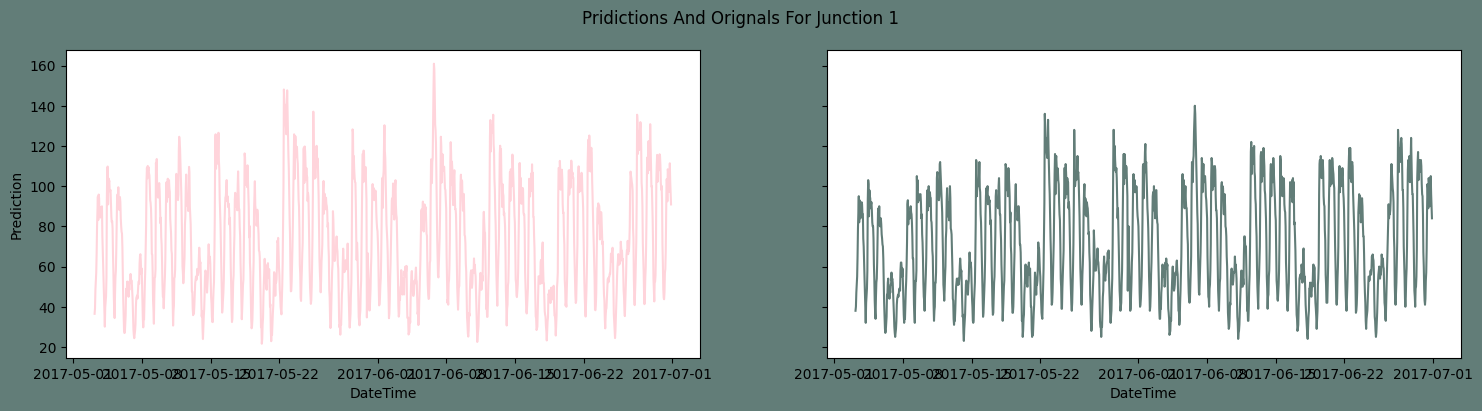

In [50]:
# invert the differenced forecast for Junction 1
recover1 = dataframe_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalization J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + avg_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with originals
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], dataframe_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

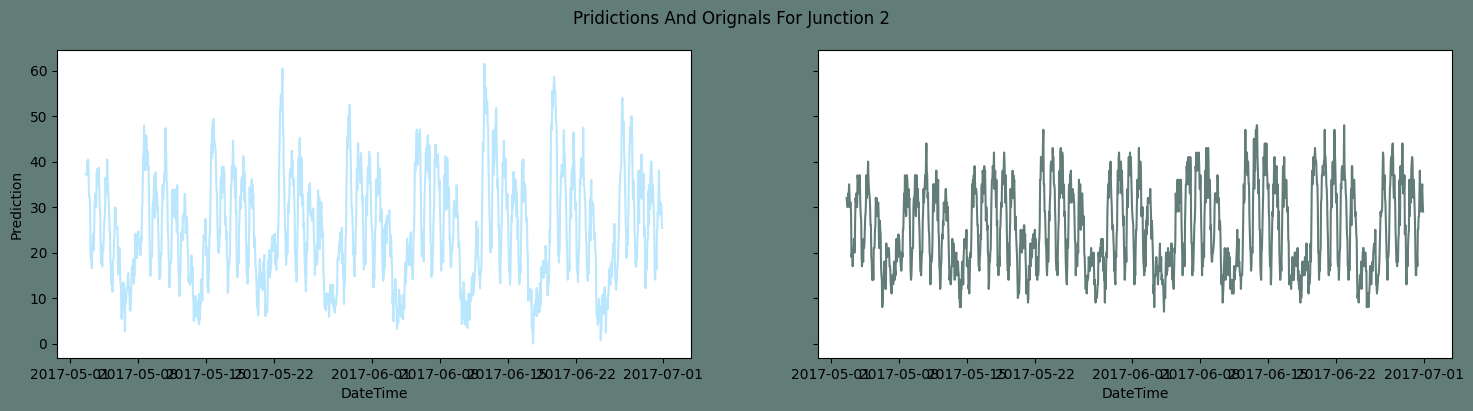

In [51]:
#Invert the differenced J2
recover2 = dataframe_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + avg_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with originals
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], dataframe_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

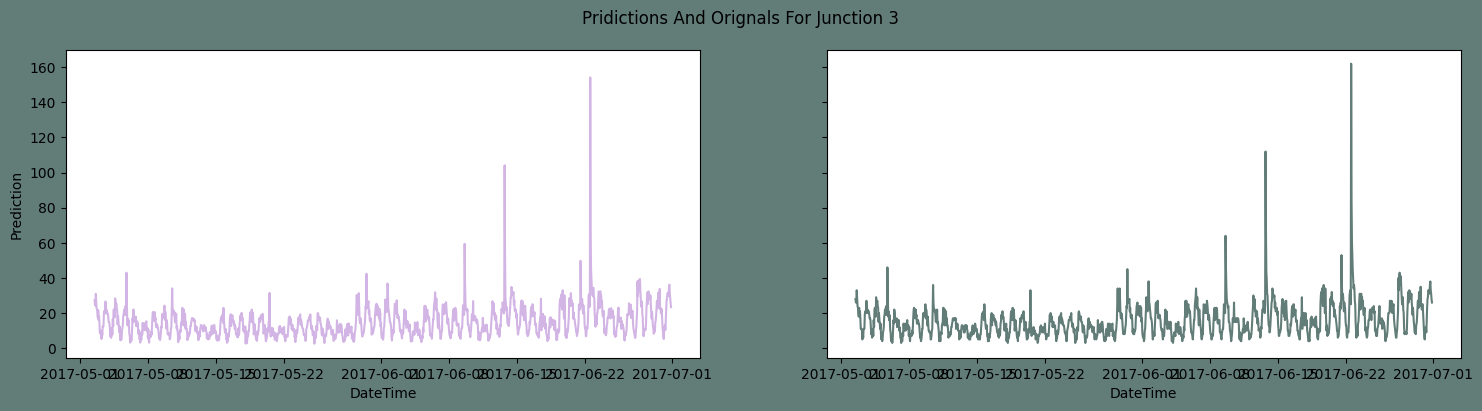

In [52]:
#Invert the differenced J3
recover3 = dataframe_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalization J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + avg_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], dataframe_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

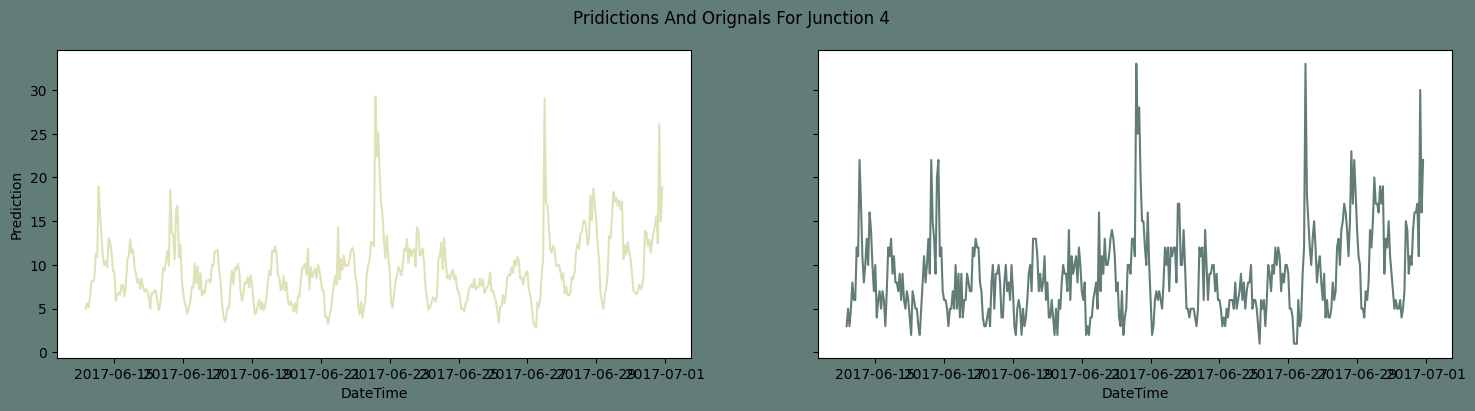

In [53]:
#Invert the differenced J4
recover4 = dataframe_N4.Norm[-404:-1].to_frame()  #len as per the test set
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalization J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + avg_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], dataframe_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)